In [16]:
!pip install numpy pandas pandas_datareader matplotlib yfinance scikit-learn xgboost tensorflow

## Imports


In [22]:
# stat data analyzing libraries
import numpy as np
import pandas as pd
from pandas_datareader import data as pdata
from datetime import datetime as dtim, timedelta as tdel

# projecting data libraries
import matplotlib.pyplot as plt

# financial data libraries
import yfinance as yf

# ML libraries
import mlflow as mlf
import xgboost as xgb
from sklearn.preprocessing import StandardScaler as ssc
from sklearn.model_selection import TimeSeriesSplit as tss
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    r2_score as r2s,
)
from tensorflow.keras.models import Sequential as seqMD
from tensorflow.keras.layers import LSTM, Dense, Dropout as dpMD

# other miscellaneous libraries
import json
import joblib

# Data Intake & Refine Pipeline


In [23]:
class DataPipeline:

    # Constructor for pipeline.
    def __init__(self, asset, trading_day_window=30, active_total_trading_days=252):
        self.asset = asset
        self.trading_window = trading_day_window
        self.active_days = active_total_trading_days
        self.scaling_factor = np.sqrt(active_total_trading_days)
        self.dataframe = None
        self.features = None
        self.scaled_features = None

    ## Fetching past for the asset for this interval of time.
    def fetch_financial_data(self, start_date, end_date):

        # this dataframe holds OHLCV data. (Open, HIgh, Low, Close, Volume).
        # dataframe = yf.download(tickers=self.asset, start=start_date, end=end_date)
        dataframe = yf.download(self.asset, start=start_date, end=end_date)

        ## Calculating returns.
        dataframe["Returns"] = np.log(dataframe["Close"] / dataframe["Close"].shift(1))

        ## Returning the dataframe with returns calculated.
        self.dataframe = dataframe
        return dataframe

    ## Calculating Realized Volatility -> Standard Deviation of Returns from the Mean Return.
    def calculate_realized_volatility(self):
        # taken a month by default can change it accordingly.

        ## Calculating the Annual Volatility using the Rolling Window Standard Deviation and Scaling it.
        self.dataframe["RealizedVolatility"] = (
            self.dataframe["Returns"].rolling(window=self.trading_window).std()
        ) * (self.scaling_factor)

        ## Calculating High-Low Volatility
        self.dataframe["HighLowVolatility"] = np.log(
            self.dataframe["High"] / self.dataframe["Low"]
        )

        ## Calculating GARMAN KLASS Volatility using the mathematical formula
        self.dataframe["GarmanKlassVolatility"] = np.sqrt(
            (((np.log(self.dataframe["High"] / self.dataframe["Low"])) ** 2) * 0.5)
            - (
                ((2 * (np.log(2))) - 1)
                * ((np.log(self.dataframe["Close"] / self.dataframe["Open"])) ** 2)
            )
        )

        return self.dataframe

    ## Technical Indicators and features for Volatility Prediction
    def create_feature_set(self, Moving_AvgStd_window=22, lookback_period=[5, 10, 22]):

        # Ensuring the returns are present
        if "Returns" not in self.dataframe.columns:
            self.dataframe["Returns"] = np.log(
                self.dataframe["Close"] / self.dataframe["Close"].shift(1)
            )

        ## Calculating features
        # if self.features is None:
        #     self.features = pd.DataFrame(index=self.dataframe.index)
        self.features = pd.DataFrame(index=self.dataframe.index)

        ### Volume-based features
        #### this is the rolling mean
        self.features["Volume_MovAvg"] = (
            self.dataframe["Volume"].rolling(window=Moving_AvgStd_window).mean()
        )
        #### this is the rolling standard deviation
        self.features["Volume_StdDev"] = (
            self.dataframe["Volume"].rolling(window=Moving_AvgStd_window).std()
        )

        ### Price-based features
        for period in lookback_period:

            #### Moving avgs
            self.features[f"Price_MovAvg_{period}"] = (
                self.dataframe["Close"].rolling(window=period).mean()
            )
            self.features[f"Price_StdDev_{period}"] = (
                self.dataframe["Close"].rolling(window=period).std()
            )

            #### RSI -> Relative Strength Index ==> OverBought or OverSold
            delta = self.dataframe["Close"].diff()
            avg_gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
            ##### if the where condition is not satisfied then we replace it by 0
            avg_loss = (-(delta.where(delta < 0, 0))).rolling(window=period).mean()
            relative_strength = avg_gain / avg_loss
            self.features[f"RSI_{period}"] = 100 - (100 / (1 + relative_strength))

            #### Historical Volatility
            self.features[f"Hist_Vol_{period}"] = (
                self.dataframe["Returns"].rolling(window=period).std()
            ) * self.scaling_factor

        ### VWAP-> Volume Weighted Average Price
        self.features["VWAP"] = (((
            self.dataframe["Close"] * self.dataframe["Volume"]
        ).cumsum()) / ((self.dataframe["Volume"]).cumsum()))

        return self.features

    ## Preparing complete dataset for the training volatility predictor model
    def prepare_training_data(
        self,
        start_date,
        end_date,
        prediction_horizon=5,
        Moving_AvgStd_window=22,
        lookback_period=[5, 10, 22]
    ):
        self.fetch_financial_data(start_date, end_date)
        self.calculate_realized_volatility()
        self.create_feature_set(Moving_AvgStd_window, lookback_period)

        # Target variable -> Future Volatility
        target = self.dataframe["RealizedVolatility"].shift(-(prediction_horizon))

        # Combining features and target
        final_dataset = pd.concat(
            [self.features, target], axis=1
        ).dropna()  #### dropping the columns with missing values from the data set

        # Getting the feature names before scaling
        feature_cols = final_dataset.columns[:-1]  ### all columns except the target
        print(feature_cols.shape)

        ### starting the standard scaler
        scaler = ssc()

        print(final_dataset.iloc[:,:-1].shape)

        # Fit and transform the features (target not included)
        scaled_features = scaler.fit_transform(final_dataset.iloc[:, :-1])

        ## Convert scaled features back to dataframe with correct column names
        self.scaled_features_df = pd.DataFrame(
            scaled_features, index=final_dataset.index, columns=feature_cols
        )

        return self.scaled_features_df, final_dataset["RealizedVolatility"], scaler

# Model to Learn Volatility


In [24]:
class VolatilityPredictor:

    # Constructor
    def __init__(self, model_type="xgboost"):
        self.model_type = model_type
        self.model = None

    # Create XGBoost model with optimized parameters for volatility prediction
    def create_xgboost_model(
        self,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42,
    ):
        return xgb.XGBRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            gamma=gamma,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            objective=objective,
            random_state=random_state,
        )

    # Create LSTM model for sequence-based volatility prediction
    def create_lstm_model(
        self,
        input_shape,
        no_lstm_layers=50,
        dropout=0.2,
        dense=1,
        optimizer="adam",
        loss="mse"
    ):
        model = seqMD(
            [
                LSTM(no_lstm_layers, return_sequences=True, input_shape=input_shape),
                dpMD(dropout),
                LSTM(no_lstm_layers),
                dpMD(dropout),
                Dense(dense)
            ]
        )
        model.compile(optimizer=optimizer, loss=loss)
        return model

    # Prepare for LSTM model
    def prepare_LSTM_sequences(self, X, sequence_length=10):
        sequences = []
        lenX = len(X)
        for i in range(lenX - sequence_length):
            sequences.append(X[i : (i + sequence_length)])
        return np.array(sequences)

    # Training on Volatility prediction model
    def train(
        self, X, y, validation_split=0.2, target_seq_len=10, epochs=50, batch_size=32, create_new_model=False
    ):
        if self.model_type == "xgboost":
            if (create_new_model):
                self.model = self.create_xgboost_model()
            self.model.fit(X, y)
            return
        elif self.model_type == "LSTM":
            X_seq = self.prepare_LSTM_sequences(X, target_seq_len)
            y_seq = y[target_seq_len:] # adjust for target for the sequence length
            if (create_new_model):
                self.model=self.create_lstm_model((X_seq.shape[1],X_seq.shape[2]))
            self.model.fit(
                X_seq,
                y_seq,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=validation_split,
            )
            return
        

    # Evaluation of model based on performance using multiple metrics
    def evaluate(self, X_test, y_test,target_seq_len=10):
        if self.model_type == "xgboost":
            prediction = self.model.predict(X_test)
        elif self.model_type == "LSTM":
            X_test_seq = self.prepare_LSTM_sequences(X_test)
            prediction = self.model.predict(X_test_seq)
            y_test=y_test[target_seq_len:]

        metrics = {
            "RMSE": np.sqrt(mse(y_test, prediction)),  ## root mean square error
            "MAE": mae(y_test, prediction),  ## mean absolute error
            "R2": r2s(y_test, prediction),  ## r2 score
        }

        return metrics,prediction

    # Making the volatility predictions on new data
    def predict(self, X):
        if self.model_type == "xgboost":
            return self.model.predict(X)
        elif self.model_type == "LSTM":
            return self.model.predict(self.prepare_LSTM_sequences(X))

## Model Evaluation

In [25]:
class VolatilityPredictionSystem:
    def __init__(self, model_path=None):

        # assert model_path != None

        self.model = None
        self.scaler = None
        self.performance_log = []
        if model_path is not None:
            self.load_model(model_path)

    ## loading the trained model and scaler from disk/memory
    def load_model(self, model_path):
        assert model_path is not None

        self.model = joblib.load(f"{model_path}/model.joblib")
        self.scaler = joblib.load(f"{model_path}/scaler.joblib")

    ## save the trained model and scaler to disk/memory
    def save_model(self, model_path):
        assert model_path is not None

        joblib.dump(self.model, f"{model_path}/model.joblib")
        joblib.dump(self.scaler, f"{model_path}/scaler.joblib")

    ## Evaluate different prediction accuracy over different time horizons
    def evaluate_predictions(self, predictions, actual_values, evaluation_window=30):
        assert predictions is not None
        assert actual_values is not None
        assert evaluation_window is not None
        ### by default evaluation window is of one month

        ### calculating the error metrics
        rmse = np.sqrt(mse(actual_values, predictions))

        ### calculating the directional accuracy
        directional_correct = np.sum(
            np.sign(predictions[1:] - predictions[:-1])
            == np.sign(actual_values[1:] - actual_values[:-1])
        )

        directional_accuracy = directional_correct / (len(predictions) - 1)

        ## Calculating Running Volatility prediction error
        running_error = (
            pd.Series(predictions - actual_values).rolling(evaluation_window).std()
        )

        evaluation = {
            "rmse": rmse,
            "directional_accuracy": directional_accuracy,
            "average_running_error": running_error.mean(),
            "max_running_error": running_error.max(),
        }

        self.performance_log.append(
            {
                "time_stamp": dtim.now().strftime("%Y-%m-%d %H:%M:%S"),
                "metrics": evaluation,
            }
        )

        return evaluation

    ## Generate Prediction report
    def generate_prediction_report(
        self, asset, predictions, actual_values, start_date, end_date
    ):
        assert asset is not None
        assert predictions is not None
        assert actual_values is not None
        assert isinstance(start_date, dtim)
        assert isinstance(end_date, dtim)

        report = {
            "asset": asset,
            "prediction_period": {
                "start": start_date.strftime("%Y-%m-%d"),
                "end": end_date.strftime("%Y-%m-%d"),
            },
            "evaluation_metrics": self.evaluate_predictions(predictions, actual_values),
            "prediction_summary": {
                "mean_predicted_volatility": float(np.mean(predictions)),
                "max_predicted_volatility": float(np.max(predictions)),
                "min_predicted_volatility": float(np.min(predictions)),
                "volatility_trend": (
                    "Increasing" if predictions[-1] > predictions[0] else "Decreasing"
                ),
            },
        }

        return report

    ## Monitor model Performance overtime to detect drift.
    def monitor_model_drift(
        self, prediction_window=30, accuracy_degrading_threshold=0.6
    ):
        assert isinstance(prediction_window, int) and (prediction_window >= 1)
        assert isinstance(accuracy_degrading_threshold, float) and (
            0 < accuracy_degrading_threshold < 1
        )

        if len(self.performance_log) < 2:
            return None

        recent_performance = pd.DataFrame(
            [log["metrics"] for log in self.performance_log[-prediction_window:]]
        )

        drift_analysis = {
            "rmse_trend": recent_performance["rmse"].is_monotonic_increasing,
            "accuracy_degradation": recent_performance["directional_accuracy"].mean()
            < accuracy_degrading_threshold,
            "error_volatility": recent_performance["average_running_error"].std(),
            "requires_restraining": False,
        }

        ### setting the restraining flag if performance is degrading
        if drift_analysis["rmse_trend"] and drift_analysis["accuracy_degradation"]:
            drift_analysis["requires_restraining"] = True

        return drift_analysis
    
    ## Deploy model for real time predictions
    def deploy_model(self,asset,prediction_horizon=5,recent_data_days = 100):
        assert asset is not None
        assert (isinstance(prediction_horizon,int) and (prediction_horizon>0))
        assert (isinstance(recent_data_days,int) and (recent_data_days>0))


        today = dtim.now()
        start_date = today - tdel(days=recent_data_days)


        ### Fetch latest data
        Dpipe = DataPipeline(asset=asset)
        data = Dpipe.fetch_financial_data(start_date=start_date,end_date=today)
        features = Dpipe.create_feature_set()

        ### Scaling features
        scaled_features = self.scaler.transform(features.iloc[-prediction_horizon:])

        ### Make Prediction
        prediction = self.model.predict(scaled_features)

        return {
            "asset" : asset,
            "prediction_date":today.strftime('%Y-%m-%d'),
            "predicted_volatility":float(prediction[-1]),
            "confidence_metrics":self.monitor_model_drift()
        }

### Model Builder

- build the model and train it, back-test it and provided the trained and corrected model


In [26]:
class ModelBuilder:
    def __init__(
        self,
        asset,
        input_shape,
        start_date,
        end_date,
        test_start,
        test_end,
        pipeline=None,
        trading_day_window=30,
        active_total_trading_days=252,
        model_type="xgboost",
        no_lstm_layers=50,
        dropout=0.2,
        dense=1,
        optimizer="adam",
        loss="mse",
    ):
        assert trading_day_window > 0 and active_total_trading_days > trading_day_window
        self.asset = asset
        self.start_date = start_date
        self.end_date = end_date
        self.test_start = test_start
        self.test_end = test_end
        if (pipeline==None):
            self.pipeline = DataPipeline(
                asset=asset,
                trading_day_window=trading_day_window,
                active_total_trading_days=active_total_trading_days,
            )
        else:
            assert pipeline.__class__ == DataPipeline
            self.pipeline=pipeline
        if model_type == "xgboost":
            self.predictor = VolatilityPredictor(model_type=model_type)
            self.predictor.model = self.predictor.create_xgboost_model()
        elif model_type == "LSTM":
            assert input_shape != None
            self.predictor = VolatilityPredictor(model_type=model_type)
            self.predictor.model = self.predictor.create_lstm_model(
                input_shape, no_lstm_layers, dropout, dense, optimizer, loss
            )
        return

    def model_train(self, train_start, train_end, test_start, test_end):
        print(f"Preparing Training Data from Yahoo Finance for Asset=> {self.asset}")
        X_train, y_train, Train_scaler = self.pipeline.prepare_training_data(
            train_start, train_end
        )

        print("Training Model")
        self.predictor.train(X_train, y_train)

        print("Preparing Test Data")
        X_test, y_test, Test_scaler = self.pipeline.prepare_training_data(
            test_start, test_end
        )

        print("Making Prediction")
        metrics, predictions = self.predictor.evaluate(X_test, y_test)

        print("Calculating the additional Metrics")
        mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

        print("Preparing Results")
        results = {
            "RMSE": metrics["RMSE"],
            "MAE": metrics["MAE"],
            "R2": metrics["R2"],
            "MAPE": mape,
            "Avg. Predicted Volatility": np.mean(predictions),
            "Avg. Actual Volatility": np.mean(y_test),
            "Prediction Bias": np.mean(predictions - y_test),
            "Max Prediction Error": np.max(np.abs(predictions - y_test)),
        }

        print("Creating Comparision Plot")
        plt.figure(figsize=(12, 6))
        plt.plot(y_test.index, y_test.values, label="Actual Volatility")
        plt.plot(y_test.index, predictions, label="Predicted Volatility")
        plt.title(f"{self.asset} Volatility - Actual V/s Predicted")
        plt.xlabel("Date")
        plt.ylabel("Volatility")
        plt.legend()
        plt.grid(True)
        plt.show()

        return results, predictions, y_test

    def run_backtest(self):
        # print("Starting Backtests")
        result, predictions, actuals = self.model_train(
            self.start_date, self.train_end, self.test_start, self.test_end
        )

        # print("\n\nBackTest Results:")
        # for metric, value in result.items():
        #     print(f"{metric}:{value:.4f}")

        # print("\nCalculating Prediction Accuracy Bands")
        within_5_percent = np.mean(np.abs((predictions-actuals)/actuals) <= 0.05)*100
        within_10_percent = np.mean(np.abs((predictions-actuals)/actuals) <= 0.10)*100

        # print("\n\nPrediction Accuracy:")
        # print(f"Prediction within 5% of actual: {within_5_percent:.2f}%")
        # print(f"Prediction within 10% of actual: {within_10_percent:.2f}%")

## Deploying System for Single Asset

[*********************100%***********************]  1 of 1 completed

Preparing Training Data from Yahoo Finance for Asset=> AAPL
(15,)
(726, 15)
Training Model
Preparing Test Data



[*********************100%***********************]  1 of 1 completed


(15,)
(220, 15)
Making Prediction
Calculating the additional Metrics
Preparing Results
Creating Comparision Plot


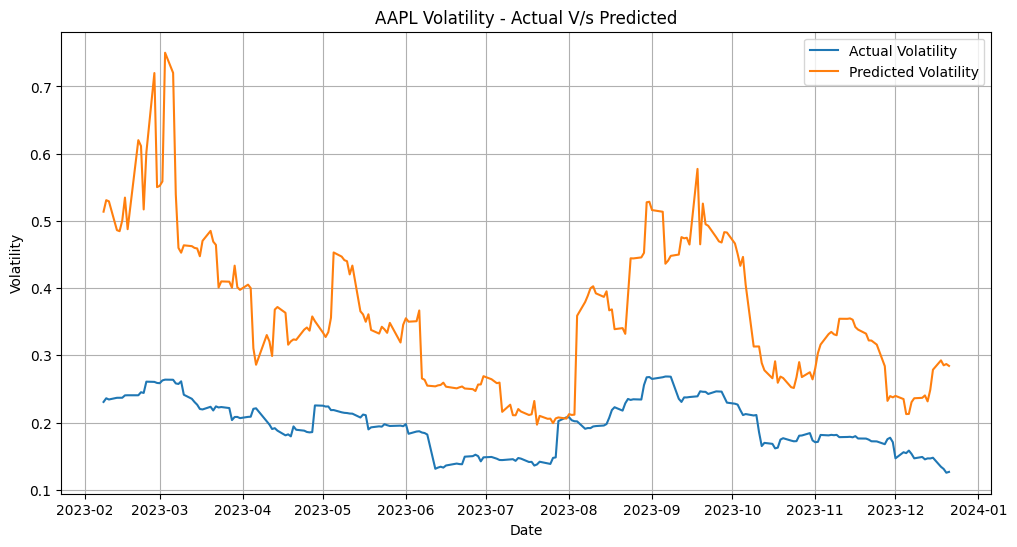

({'RMSE': np.float64(0.18153019201645945),
  'MAE': 0.16312418154141878,
  'R2': -21.907695768085564,
  'MAPE': np.float64(80.77489773227286),
  'Avg. Predicted Volatility': np.float32(0.3596248),
  'Avg. Actual Volatility': np.float64(0.19651814172032203),
  'Prediction Bias': np.float64(0.16310666100726887),
  'Max Prediction Error': np.float64(0.4864721607786701)},
 array([0.51373374, 0.53084934, 0.52913564, 0.4862481 , 0.48470616,
        0.50078875, 0.5346704 , 0.48766774, 0.620135  , 0.61144835,
        0.51705706, 0.60171205, 0.7200256 , 0.5502865 , 0.5521453 ,
        0.5587683 , 0.7502579 , 0.7202464 , 0.5395253 , 0.4598163 ,
        0.4526913 , 0.46367592, 0.46241876, 0.4598129 , 0.4589777 ,
        0.4474141 , 0.47031805, 0.48514923, 0.4691612 , 0.46427295,
        0.40087894, 0.409969  , 0.4095514 , 0.4005363 , 0.43340814,
        0.40133414, 0.39741504, 0.40513778, 0.40005237, 0.31048462,
        0.28595272, 0.33014444, 0.32067403, 0.298961  , 0.36802566,
        0.3718434

In [27]:
asset = "AAPL"
train_start = "2020-01-01"
train_end = "2023-01-01"
test_start = "2023-01-02"
test_end = "2024-01-01"

sdp = DataPipeline(asset)
# svp = VolatilityPredictor("xgboost")
smd = ModelBuilder(asset=asset,input_shape=None,start_date=train_start,end_date=train_end,test_start=test_start,test_end=test_end,pipeline=sdp)
smd.model_train(smd.start_date,smd.end_date,smd.test_start,smd.test_end)
